# Check GPU

In [68]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-680b5b06-c9be-bd51-90f7-d86a07364a1a)


# Import libraries

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# Load dataset

In [71]:
new_img="/kaggle/input/image-data/Imagedataset"

In [72]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in (os.listdir(new_img)):
    image_path = os.path.join((new_img), filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [73]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /kaggle/input/image-data/Imagedataset/69_1_25....   69       1
1  /kaggle/input/image-data/Imagedataset/29_1_133...   29       1
2  /kaggle/input/image-data/Imagedataset/68_0_45....   68       0
3  /kaggle/input/image-data/Imagedataset/79_0_141...   79       0
4  /kaggle/input/image-data/Imagedataset/64_1_433...   64       1

In [74]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

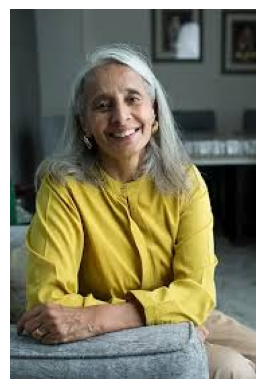

In [75]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

# Exploratory data analysis

<Axes: xlabel='age', ylabel='Density'>

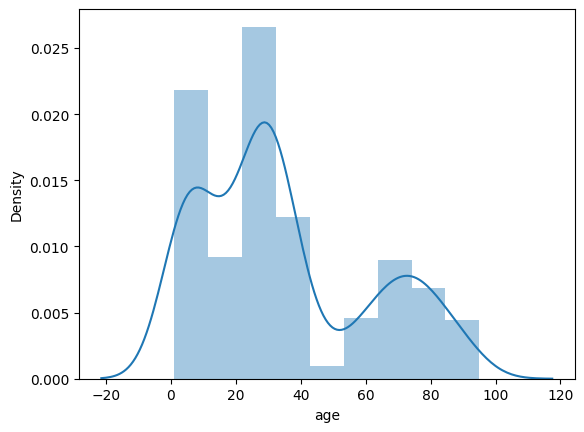

In [76]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

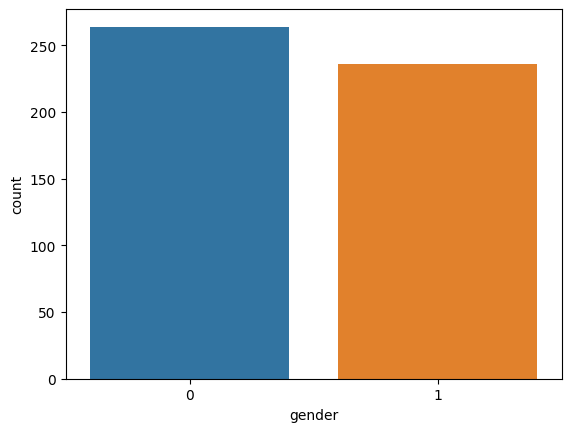

In [77]:
sns.countplot(x='gender',data=df)

# Display grid of images

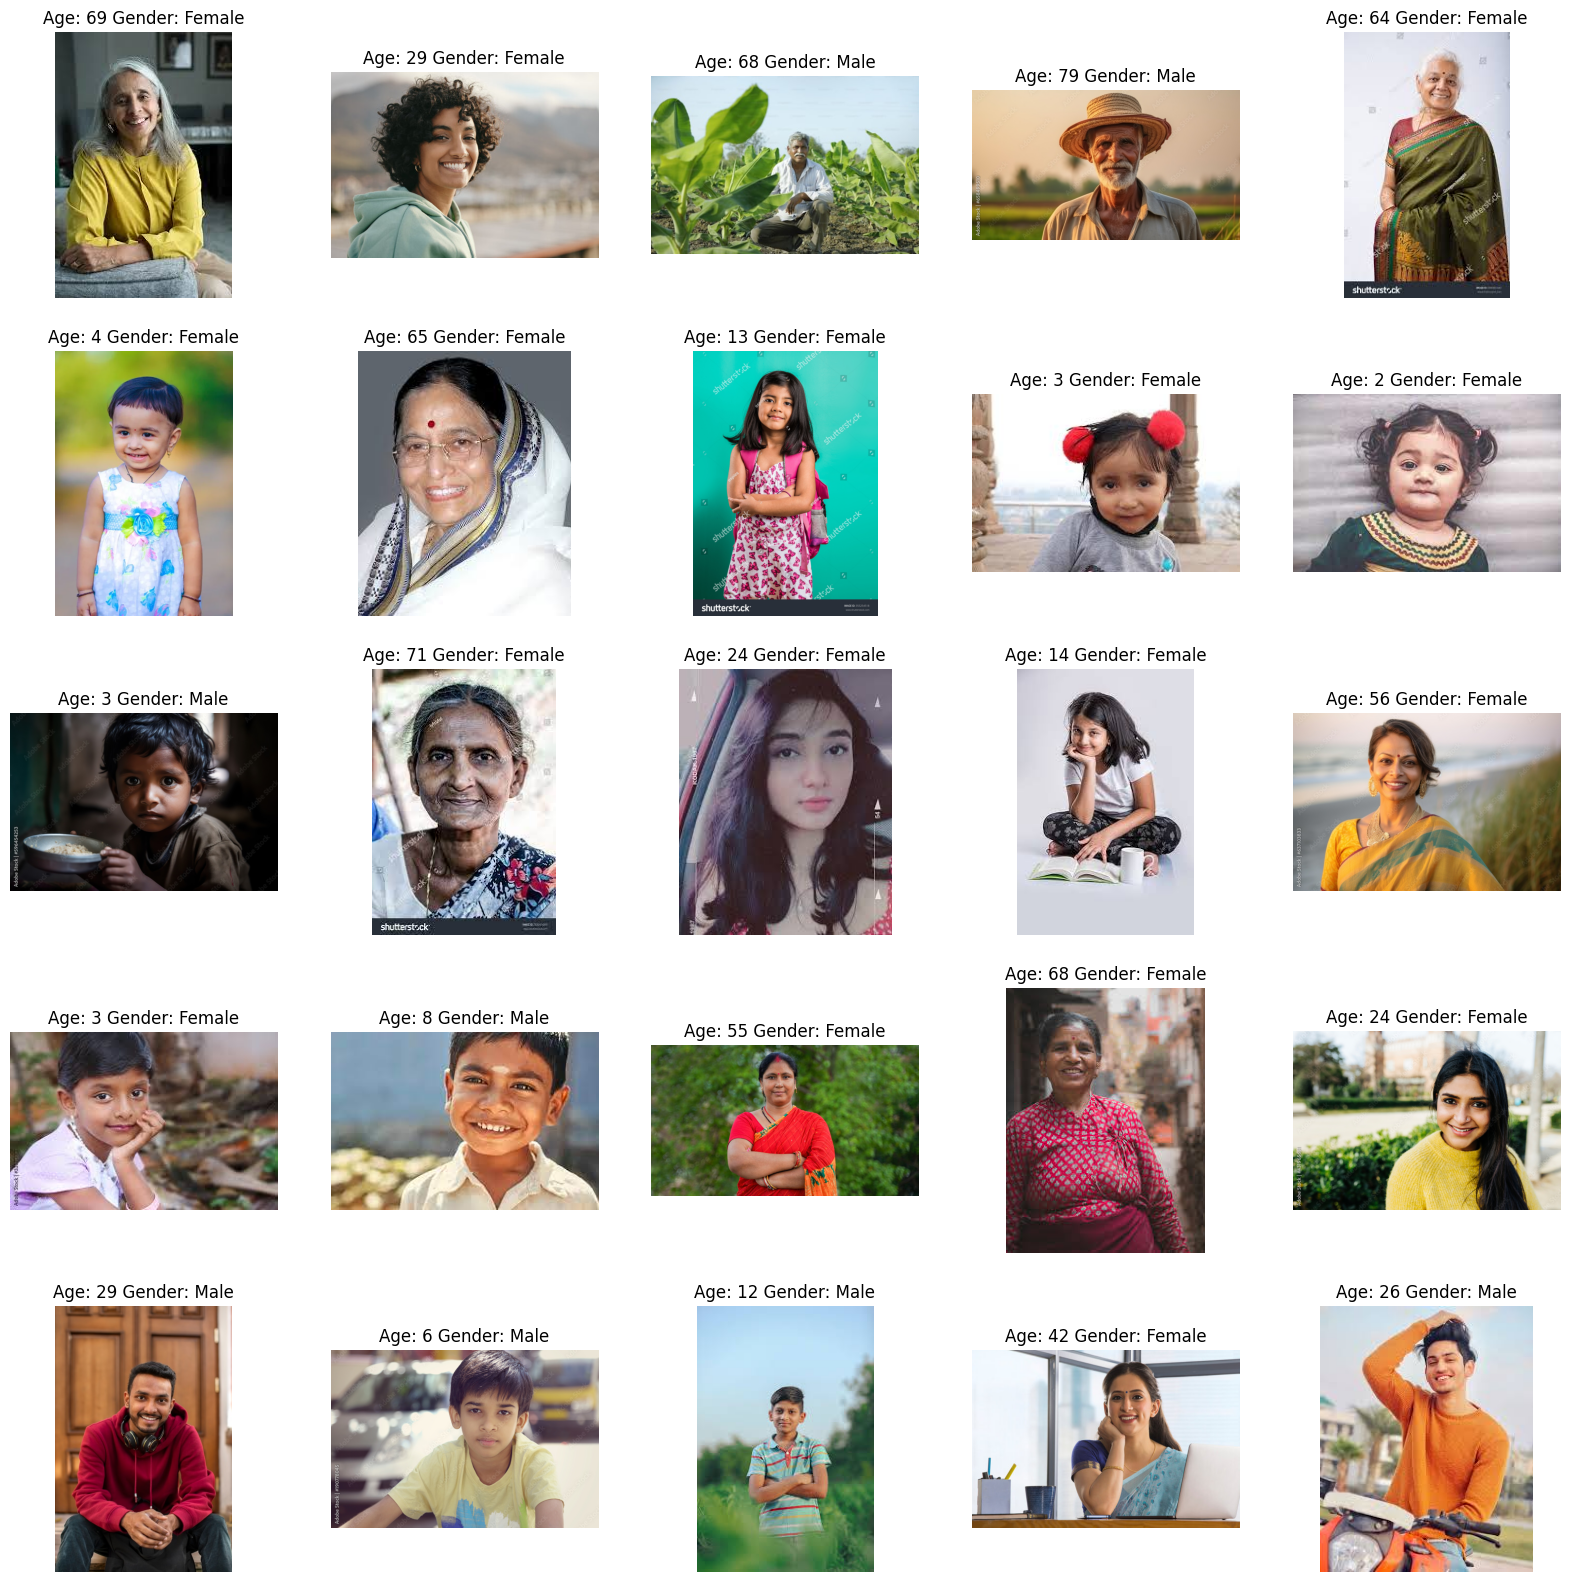

In [78]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# Feature Extraction

In [79]:
def extract_features(images):
    features = []
    for image in (images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [80]:
x=extract_features(df['image'])

# Data Normalization

In [83]:
# normalize the images
X = x/255.0

In [84]:
X[0]

array([[[0.19607843],
        [0.19215686],
        [0.19215686],
        ...,
        [0.14509804],
        [0.14117647],
        [0.14117647]],

       [[0.2       ],
        [0.19607843],
        [0.19215686],
        ...,
        [0.12156863],
        [0.11764706],
        [0.11764706]],

       [[0.20392157],
        [0.2       ],
        [0.19607843],
        ...,
        [0.2627451 ],
        [0.2627451 ],
        [0.25882353]],

       ...,

       [[0.35686275],
        [0.31764706],
        [0.31372549],
        ...,
        [0.80392157],
        [0.83529412],
        [0.59607843]],

       [[0.30588235],
        [0.29019608],
        [0.28235294],
        ...,
        [0.81176471],
        [0.79607843],
        [0.76862745]],

       [[0.28235294],
        [0.2745098 ],
        [0.2745098 ],
        ...,
        [0.77647059],
        [0.76078431],
        [0.74117647]]])

In [85]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [86]:
input_shape=(128,128,1)

In [23]:
# model_1 = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='linear'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1, activation='sigmoid', name='gender_out'),
#     tf.keras.layers.Dense(1, activation='relu', name='age_out')
# ])

# model_1.compile(loss=['binary_crossentropy', 'mae'], 
#                 optimizer=tf.keras.optimizers.Adam(), 
#                 metrics=['accuracy'])

In [87]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='linear') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], 
            optimizer=tf.keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [89]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2,verbose=False)

In [90]:
def plot_gender_results(history):
    # plot results for gender
    acc = history.history['gender_out_accuracy']
    val_acc = history.history['val_gender_out_accuracy']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training Accuracy(Gender)')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy(Gender)')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.figure()
    
    loss = history.history['gender_out_loss']
    val_loss = history.history['val_gender_out_loss']
    
    plt.plot(epochs, loss, 'b', label='Training Loss(Gender)')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss(Gender)')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

In [91]:
def plot_age_results(history):
    # plot results for age
    acc = history.history['age_out_accuracy']
    val_acc = history.history['val_age_out_accuracy']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training Accuracy (Age)')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy(Age)')
    plt.title('Accuracy Graph')
    plt.legend()
    plt.figure()
    
    loss = history.history['age_out_loss']
    val_loss = history.history['val_age_out_loss']
    epochs = range(len(loss))
    
    plt.plot(epochs, loss, 'b', label='Training Loss(Age)')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss(Age)')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

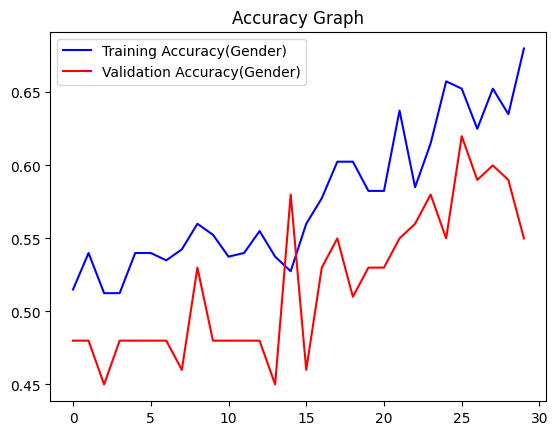

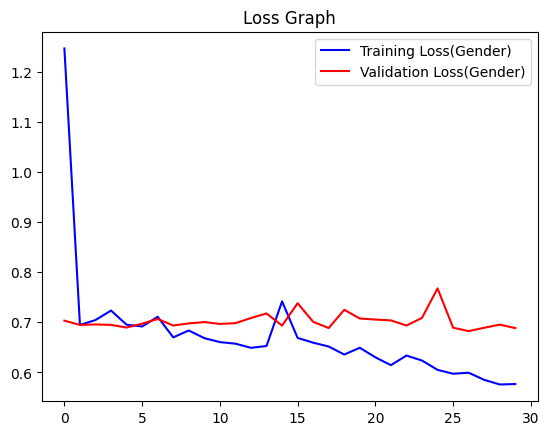

In [92]:
# plot results for gender
plot_gender_results(history)

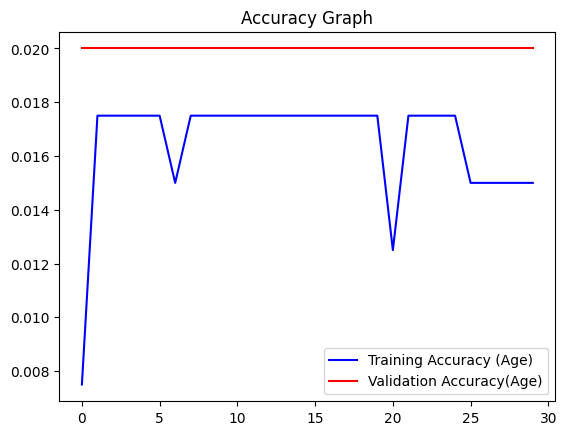

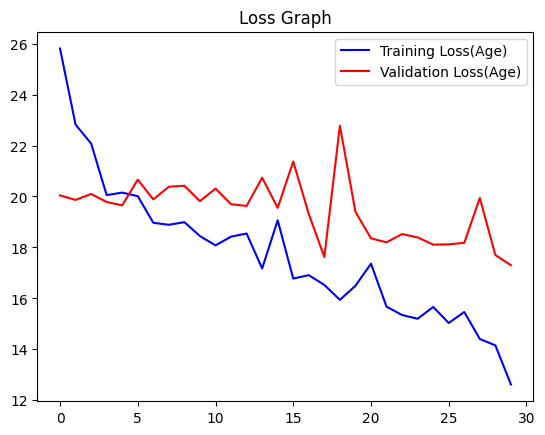

In [93]:
# plot results for age
plot_age_results(history)

Original Gender: Male Original Age: 68
1/1 [==============================] - 0s 98ms/step
Predicted Gender: Male Predicted Age: 63


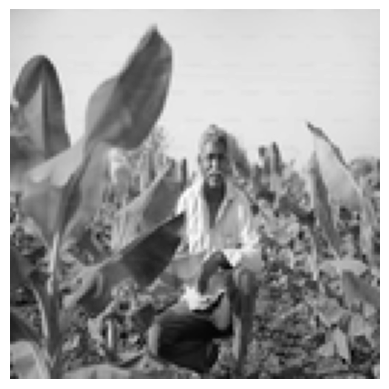

In [94]:
image_index = 2
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 79
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: 36


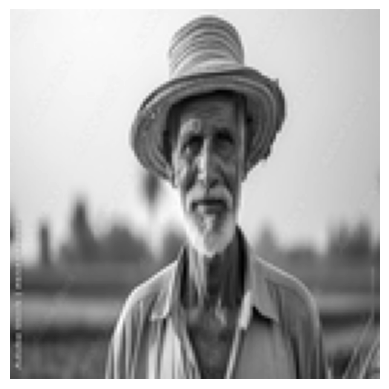

In [95]:
image_index = 3
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [96]:
model.save("First_model.hdf5")
print("Model saved successfully")

Model saved successfully


# Increase number of layers

In [98]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
conv_5 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_4)
maxp_5 = MaxPooling2D(pool_size=(2, 2)) (conv_5)
conv_6 = Conv2D(512, kernel_size=(3, 3), activation='relu',padding="same" ) (maxp_5)
maxp_6 = MaxPooling2D(pool_size=(2, 2)) (conv_6)

flatten = Flatten() (maxp_6)


# fully connected layers
dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model_2 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_2.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [100]:
# # plot the model
# plot_model(model_2)

In [102]:
# train model
history_2 = model_2.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2,verbose=False)

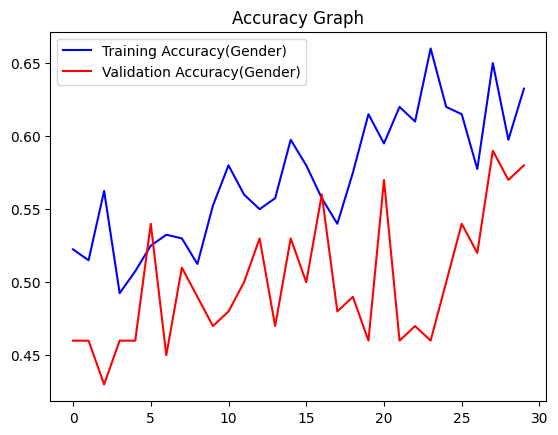

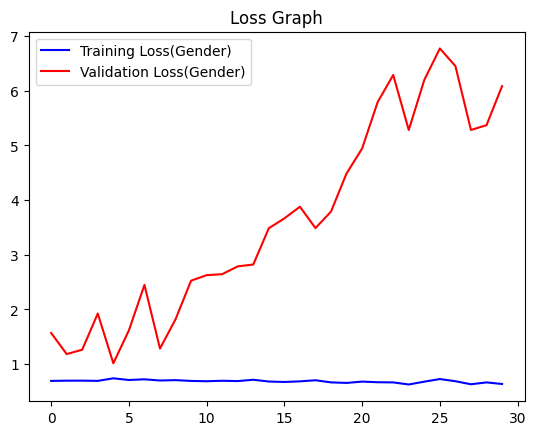

In [103]:
plot_gender_results(history_2)

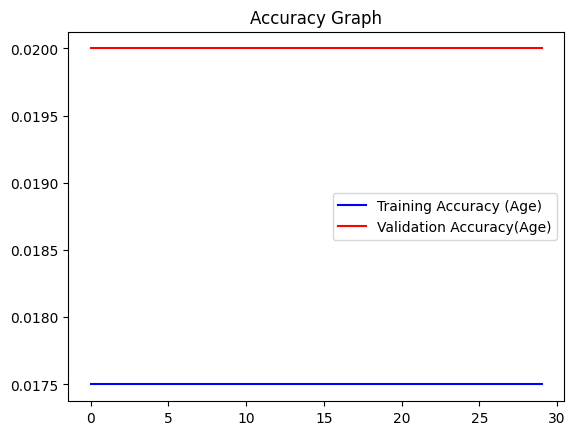

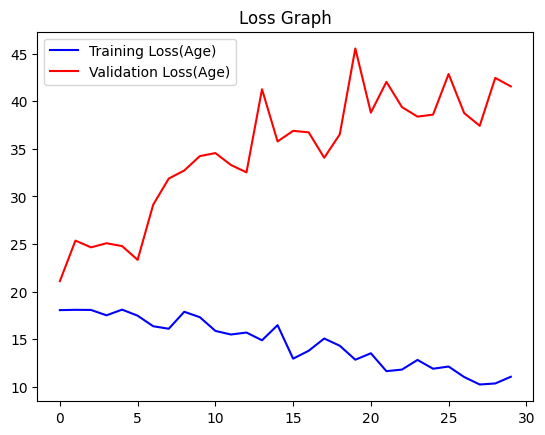

In [104]:
plot_age_results(history_2)

Original Gender: Female Original Age: 28
1/1 [==============================] - 0s 130ms/step
Predicted Gender: Male Predicted Age: 26


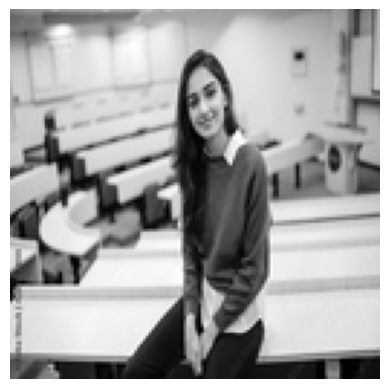

In [105]:
image_index = 40
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model_2.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_2 = gender_dict[round(pred[0][0][0])]
pred_age_2 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_2, "Predicted Age:", pred_age_2)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128),cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: 31


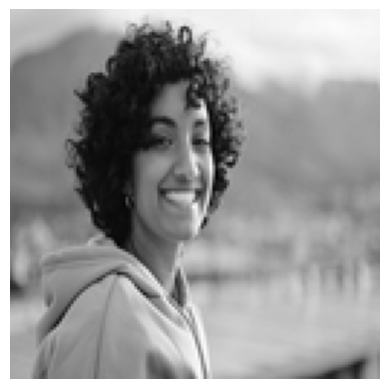

In [106]:
image_index = 1
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model_2.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_2 = gender_dict[round(pred[0][0][0])]
pred_age_2 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_2, "Predicted Age:", pred_age_2)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [107]:
model_2.save("Second_model.hdf5")
print("Model saved successfully")

Model saved successfully


# Decrease number of layers

In [108]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

flatten = Flatten() (maxp_3)


# fully connected layers
dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model_3 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_3.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [109]:
# train model
history_3 = model_2.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2,verbose=False)

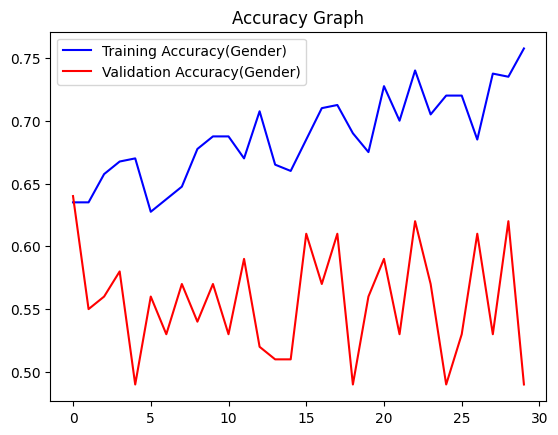

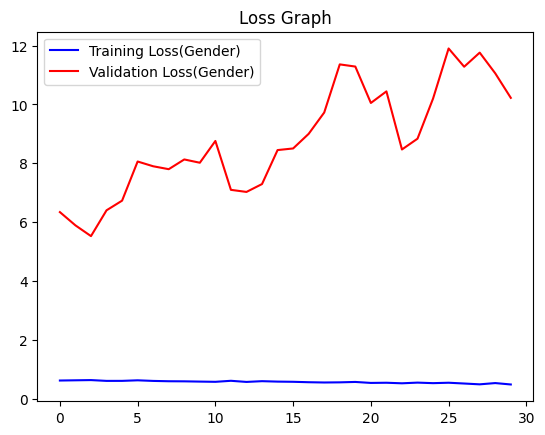

In [110]:
plot_gender_results(history_3)

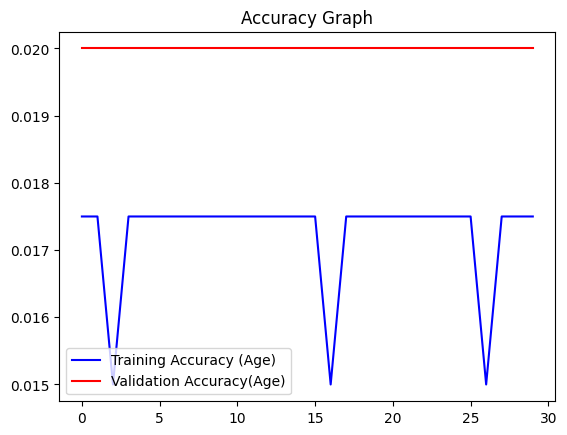

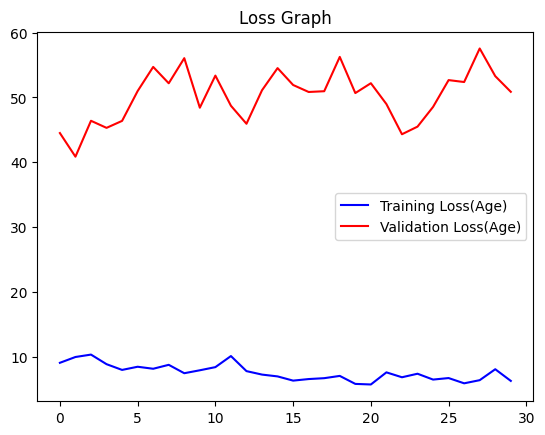

In [111]:
plot_age_results(history_3)

Original Gender: Female Original Age: 28
1/1 [==============================] - 0s 89ms/step
Predicted Gender: Female Predicted Age: 0


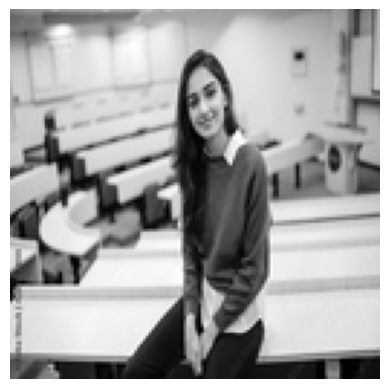

In [112]:
image_index = 40
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model_3.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_3 = gender_dict[round(pred[0][0][0])]
pred_age_3 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_3, "Predicted Age:", pred_age_3)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128),cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: 0


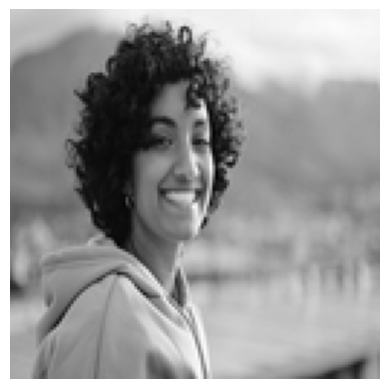

In [113]:
image_index = 1
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model_3.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_3 = gender_dict[round(pred[0][0][0])]
pred_age_3 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_3, "Predicted Age:", pred_age_3)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128),cmap='gray');

In [119]:
model_3.save("Third_model.hdf5")
print("Model saved successfully")

Model saved successfully


# Add learning rate

In [115]:
#add learning rate
input_shape=(128,128,1)
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(1287, kernel_size=(3, 3), activation='linear') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model_4 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_4.compile(loss=['binary_crossentropy', 'mae'], 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                metrics=['accuracy'])


In [116]:
# train model
history_4= model_4.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 4s 47ms/step - loss: 3242.8159 - gender_out_loss: 1852.4269 - age_out_loss: 1390.3888 - gender_out_accuracy: 0.4775 - age_out_accuracy: 0.0075 - val_loss: 1159.4694 - val_gender_out_loss: 1126.0994 - val_age_out_loss: 33.3700 - val_gender_out_accuracy: 0.4800 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
13/13 [==============================] - 0s 18ms/step - loss: 581.3729 - gender_out_loss: 546.7203 - age_out_loss: 34.6525 - gender_out_accuracy: 0.5625 - age_out_accuracy: 0.0000e+00 - val_loss: 431.2552 - val_gender_out_loss: 397.8852 - val_age_out_loss: 33.3700 - val_gender_out_accuracy: 0.4800 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
13/13 [==============================] - 0s 18ms/step - loss: 251.6406 - gender_out_loss: 216.9881 - age_out_loss: 34.6525 - gender_out_accuracy: 0.5025 - age_out_accuracy: 0.0000e+00 - val_loss: 78.4106 - val_gender_out_loss: 45.0406 - val_age_out_loss: 33.3700 - val_gender_out_accuracy: 0.4800 

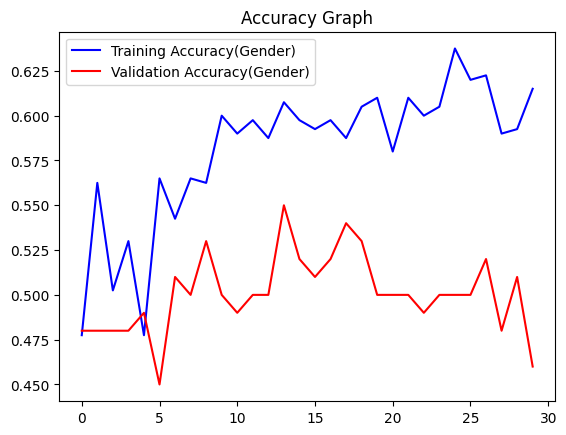

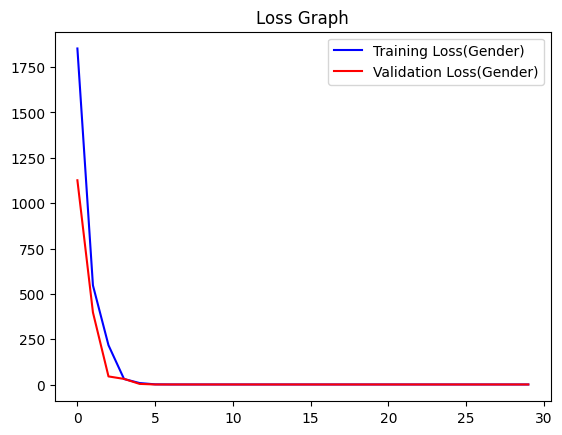

In [117]:
plot_gender_results(history_4)

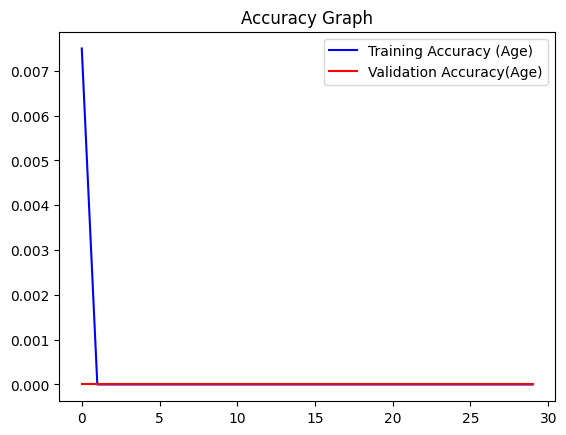

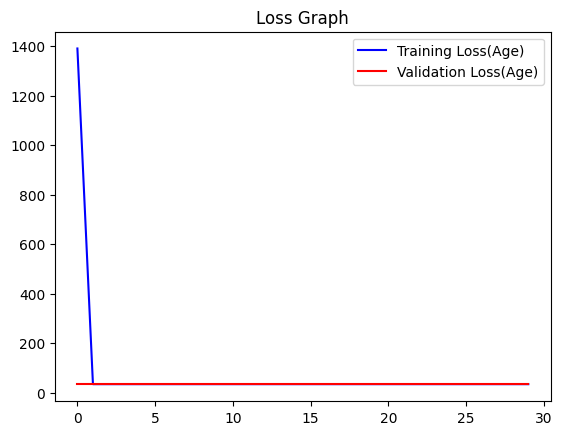

In [118]:
plot_age_results(history_4)

In [120]:
model_4.save("Fourth_model.hdf5")
print("Model saved successfully")

Model saved successfully


Original Gender: Male Original Age: 18
1/1 [==============================] - 0s 117ms/step
Predicted Gender: Female Predicted Age: 0


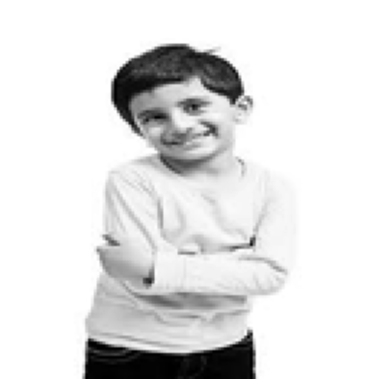

In [121]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred_4 = model_4.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_4 = gender_dict[round(pred[0][0][0])]
pred_age_4= round(pred[1][0][0])
print("Predicted Gender:", pred_gender_4, "Predicted Age:", pred_age_4)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 3
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: 0


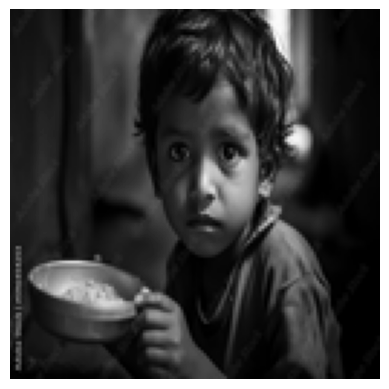

In [122]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred_4 = model_4.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_4 = gender_dict[round(pred[0][0][0])]
pred_age_4= round(pred[1][0][0])
print("Predicted Gender:", pred_gender_4, "Predicted Age:", pred_age_4)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

# Train for longer

In [123]:
#Train for longer (increase number of epochs)

inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(16, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(32, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(128, kernel_size=(3, 3), activation='linear') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(512, activation='relu') (flatten)
dense_2 = Dense(512, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model_5 = Model(inputs=[inputs], outputs=[output_1, output_2])

model_5.compile(loss=['binary_crossentropy', 'mae'], 
                optimizer="adam", 
                metrics=['accuracy'])

In [124]:
# train model
history_5 = model_5.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
13/13 [==============================] - 3s 32ms/step - loss: 26.3262 - gender_out_loss: 1.0211 - age_out_loss: 25.3050 - gender_out_accuracy: 0.5375 - age_out_accuracy: 0.0150 - val_loss: 22.3028 - val_gender_out_loss: 0.8276 - val_age_out_loss: 21.4752 - val_gender_out_accuracy: 0.5200 - val_age_out_accuracy: 0.0200
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 22.3474 - gender_out_loss: 0.8481 - age_out_loss: 21.4993 - gender_out_accuracy: 0.5125 - age_out_accuracy: 0.0175 - val_loss: 21.8207 - val_gender_out_loss: 0.8561 - val_age_out_loss: 20.9646 - val_gender_out_accuracy: 0.4800 - val_age_out_accuracy: 0.0200
Epoch 3/50
13/13 [==============================] - 0s 12ms/step - loss: 21.9783 - gender_out_loss: 0.7273 - age_out_loss: 21.2510 - gender_out_accuracy: 0.5525 - age_out_accuracy: 0.0175 - val_loss: 20.6843 - val_gender_out_loss: 0.7091 - val_age_out_loss: 19.9752 - val_gender_out_accuracy: 0.5000 - val_age_out_accuracy: 0.0200
Epoch 4

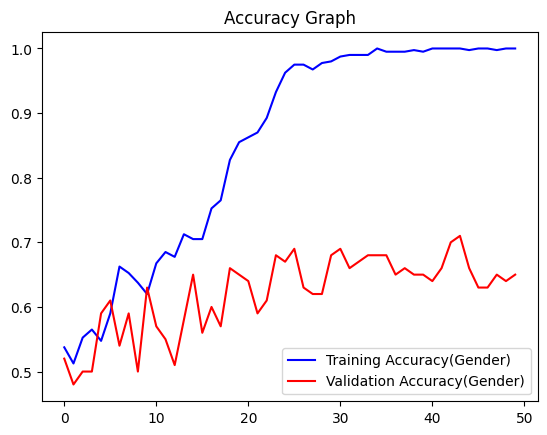

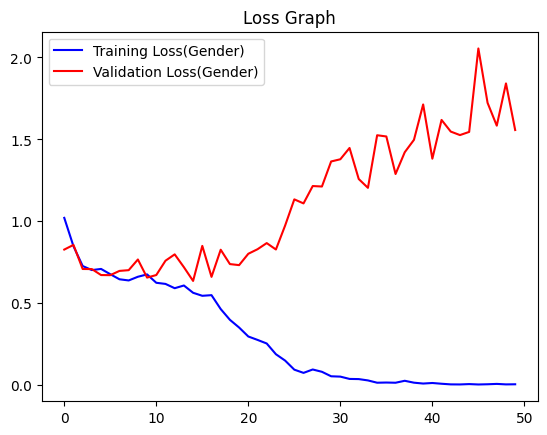

In [125]:
plot_gender_results(history_5)

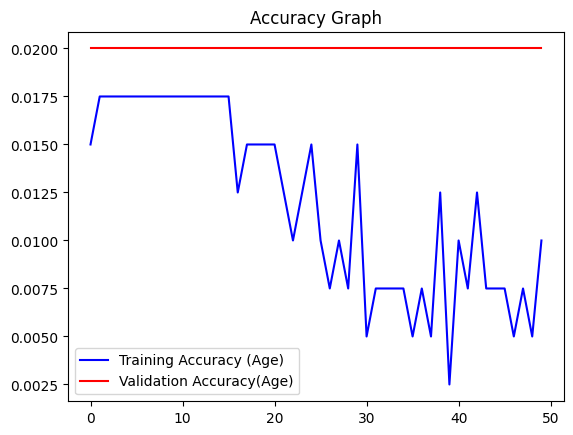

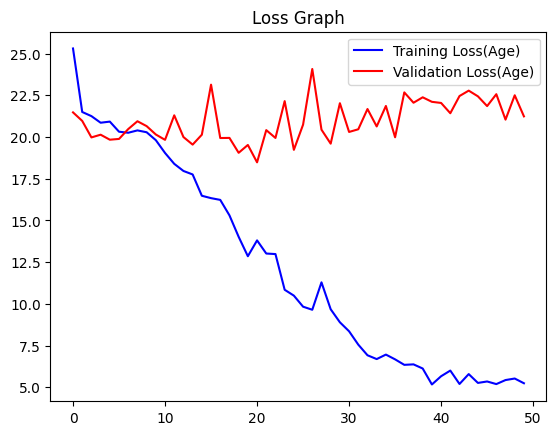

In [126]:
plot_age_results(history_5)

In [128]:
model_5.save("Model_Five.hdf5")
print("Model saved successfully")

Model saved successfully


Original Gender: Female Original Age: 15
1/1 [==============================] - 0s 95ms/step
Predicted Gender: Female Predicted Age: 0


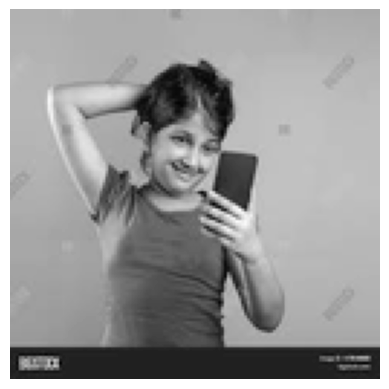

In [130]:
image_index = 101
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred_5 = model_5.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_5 = gender_dict[round(pred[0][0][0])]
pred_age_5 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_5 ,"Predicted Age:", pred_age_5)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


Original Gender: Female Original Age: 60
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 11


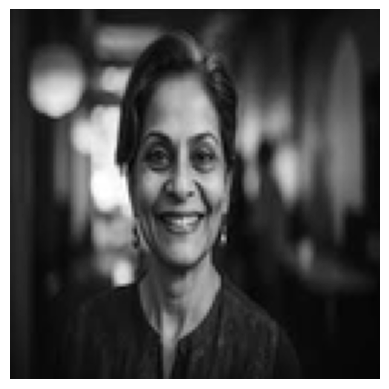

In [67]:
image_index = 101
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred_5 = model_5.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender_5 = gender_dict[round(pred[0][0][0])]
pred_age_5 = round(pred[1][0][0])
print("Predicted Gender:", pred_gender_5 ,"Predicted Age:", pred_age_5)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');


# From all the above models, it can be observed that increasing the number of hidden layers to find the gender and age of a person from the image dataset can be an optimal solution.

# THANK YOU !!